# Basic EDA and Preprocessing

Originally forked from Iain Cruickshank's notebook [here](https://www.kaggle.com/code/ijcrook/full-walkthrough-eda-fe-model-tuning). Thanks for Iain for doing alot of the work in showing us how to explore the data, and preprocessing it to calculate aggregated information about the columns,

Annotated by the "Biryani ML Scholars".

Information on the Problem:

* [Woogles](https://woogles.io/team) is an online site where people play scrabble against a bot

*** Dataset:**

      - ~73,000 Scrabble games played by three bots on Woogles.io:   
      1) BetterBot (beginner), 2) STEEBot (intermediate), and 3) HastyBot (advanced) VS. regular humans using the site


*** Task: Supervised Learning (Regression)**

       - using 1) metadata about the games and 2) turns in each game (i.e., players' racks and where and what they played, AKA gameplay), we want to predict the rating of the human opponents 

*** Evaluations:**
        
        - You will train your model on gameplay data from the train set of human opponents to make predictions about a different set of human opponents in the test set.

In [1]:
! pip install -U textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.0 MB/s eta 0:00:00a 0:00:01


In [2]:
# Exploratory Data Analysis
import os, random, textstat
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas_profiling import ProfileReport
from scipy.stats import mode
# Make pretty plots 
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Data Preprocessing
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Parametric/Non-Parametric/Ensemble/Probabilistic models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.naive_bayes import MultinomialNB

import optuna  # hyperparameter optimization

# Useful library to use for Gradient-Boosted Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor, Dataset

# Model Evaluation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold

In [3]:
'''Set the directory for the data'''

ROOT_DIR = "../input/scrabble-player-rating"

# 1. Exploratory Data Analysis
- look at the dataset basics (size of the data, data types, look at a few examples etc.)
- look for any missing data
- look at target value

## More Dataset Info 

See this [link](https://www.kaggle.com/competitions/scrabble-player-rating/data) to refresh on the different files and what all the fields mean.

See this [video](https://www.youtube.com/watch?v=lG1QAyWvKlQ) for an explanation on how Scrabble works.

## 1(a) Profile the different datasets present in the data

We use `PandasProfling` to automate the process of creating a lot of plots for this dataset.

In [ ]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
# for the test data - I'm using the CSV that includes 50% non-NaN values in the ratings column
test = pd.read_csv(os.path.join("../input/fulltestcsv", "test.csv"))
turns = pd.read_csv(os.path.join(ROOT_DIR, "turns.csv"))
games = pd.read_csv(os.path.join(ROOT_DIR, "games.csv"))
sub = pd.read_csv(os.path.join(ROOT_DIR, "sample_submission.csv"))

# the first five rows of each DataFrame, visualized in one cell
display(train.head())
display(test.head())
display(turns.head())
display(games.head())
display(sub.head())

In [ ]:
print("train shape:", train.shape)
print("test shape:", test.shape)
print("turns shape:", turns.shape)
print("games shape:", games.shape)
print("submission shape:", sub.shape)

In [ ]:
# ProfileReport(train)

In [ ]:
# ProfileReport(test)

In [ ]:
# ProfileReport(turns)

In [ ]:
# ProfileReport(games)

From the initial dataset profiling
- There are some missing values that we need to look into

## 1(b) look at the missing values
- look for any patterns in missing data
- look at some examples of missing data

In [ ]:
turns.isna().sum()

Begin with looking at the missing data in the 'rack' variable

In [ ]:
turns[turns['rack'].isna()].head()

In [ ]:
'''Display counts and types of data point where rack is blank'''

np.unique(turns[turns['rack'].isna()]['turn_type'], return_counts=True)

Ok, so I think we can at least make sense of the above - it tells us that at 1) when challenging a word from the opponent, or 2) at the end of the game and 3) during timeouts, the player has no letters on their rack (which I believe is expected). 

In [ ]:
np.unique(turns[turns['rack'].isna()]['move'], return_counts=True)

^This code above can be used to find the *distribution of move types*, specifically for turns where the rack was empty.

Next, look at the missing data in `turn_type`:

In [ ]:
turns[turns['turn_type'].isna()].head()

Interesting - so from all of five rows of the above, it looks like in places where `turn_type` is NaN, so is `move`.

Going further, let's see if we can confirm if there's a correlation between `turn_type` being NaN, and the `move` column being NaN: 

In [ ]:
turns[turns['turn_type'].isna()].shape[0], turns[turns['move'].isna()].shape[0]

Alright, so not quite a 1:1 ratio. But pretty close...
Anyway - let's see if there are any NaN values in the games dataset:

In [ ]:
games.isna().sum()

In [ ]:
test.isna().sum()

More Takeaways:
- the missing data in the test file appears to the be missing target variable (i.e. the rating of the player before that game)
- Both the `move` and `location` have NaN's for games in the test set. `location` and `rack` are also NaN if a player did not place pieces. We must be careful in handling these NaN's. 
- Also, let's keep in mind we need to use __previous__ games to the test games (we should also look to see if the test games are the final game in the string of games for all of the players).

## 1(c) Look at the target variable

In [ ]:
plt.figure(figsize=(14,10))
sns.histplot(train['rating'], ax=plt.gca())
plt.title("Discrete Distribution of Ratings")
plt.show()

In [ ]:
print(f"Primary mode of the target variable: {mode(train['rating']).mode[0]}.")
print(f"Secondary mode of the target variable: {mode(train[train['rating'] != 1500]['rating']).mode[0]}.")

The ratings have a couple of different "local" peaks of values (which signify the modes of the dataset) and a "global" peak at 1500. Perhaps this is the inital rating assigned to a new user? We will need to look more into this particular value, especially to see if 1) it occurs for all users, and 2) if so, when.

## 1(d) EDA of the Games

Based on the observations from the first part of the EDA, lets look to see the following:

1. How many games does each non-bot player have?
2. What do the course of a players games' look like? Is it different between bots?
3. When does the '1500' player rating occur?
4. Are there any patterns in the variables that we might be able to exploit for determining a player's ratings over the course of their games?

In [ ]:
bot_names =["BetterBot", "STEEBot", "HastyBot"]  # from the dataset description

# grabbing the # of times each non-bot player appears across the games in the training data
names, counts= np.unique(train[~train['nickname'].isin(bot_names)]['nickname'], return_counts=True)
# plotting the univariate dist. of how many games each non-bot player has
plot = sns.displot(counts, kind='ecdf')
plot.fig.suptitle("Cumulative distibution of number of games per player")
plt.show()

In [ ]:
'''Look at Game Stats per User'''

print(f"Most games played by a user: {list(reversed(np.sort(counts)[-10:]))}.")
print(f"Mean games played by a user: {np.mean(counts)}.")
print(f"Median games played by a user: {int(np.median(counts))}.")

In [ ]:
'''create a dataframe of the bot information for each of the games'''

# first, "clear" out any rows unrelated to the bots - by making a new column
bot_df = train[["game_id", "nickname", "score", "rating"]].copy()
bot_df['bot_name'] = bot_df['nickname'].apply(lambda x: x if x in bot_names else np.nan)
bot_df = bot_df[["game_id", "score", "rating", "bot_name"]].dropna(subset=["bot_name"])
# now we can forget about the nickname col, and just focus on the bots
bot_df.columns = ["game_id", "bot_score", "bot_rating", "bot_name"]

In [ ]:
'''collecting all the data in one object'''

# take out the bot info
full_df = train[~train['nickname'].isin(bot_names)]
# add in bot information
full_df = full_df.merge(bot_df, on="game_id")
# add in game info
full_df = full_df.merge(games, on="game_id")
# transform the date and time to a format pandas understands
full_df["created_at"] = pd.to_datetime(full_df["created_at"])

In [ ]:
'''Check for any non-bot games (i.e. human on human)'''

num_human_on_human = full_df[full_df['bot_name'].isna()].shape[0]
print(f"No. of non-bot games: {num_human_on_human}.")

In [ ]:
''' Pick a random nickname and look at their ratings over the course of their games'''

nickname = full_df["nickname"].sample(1).values[0]
print(f"Random Nickname: {nickname}.")

full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title(f"Player '{nickname}' ratings over the course of their games, by bot.")

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title(f"Player '{nickname}' scores over the course of their games, by bot.")
plt.show()

So, most players have very few games (less than 12), and some have a lot (could this be an example of Pareto's Law?). And, players only play against bots. Also, some players do play different bots over the course of their games. Players' ratings also change with time, and exhibit a variety of different patterns as they do so. And, all of the games are against some kind of bot. 

__However__, we also need to note that we are not given any of the ratings nor any of the moves or locations for any of the players in the test set.

Now, let's turn to looking at when the rating of `1500` occurs for players...

In [ ]:
'''How many users have a 1500 rating ever?'''

users, counts = np.unique(full_df[full_df['rating'] == 1500]['nickname'], return_counts=True)

print(f"Number of users with a `1500` rating: {len(users)}.")
print(f"Counts per user: \n {counts}.")

In [ ]:
'''look at those users that have more than one 1500 rating'''

print("Users with a high number of 1500 ratings: ")
users_high_1500_ratings = users[np.argsort(counts)[::-1][:34]]
print(users_high_1500_ratings)  # only showing the top 34 of >1x1500 ratings
print("\n...and their counts of 1500 scores: ")
print(counts[np.argsort(counts)[::-1][:34]])

In [ ]:
'''Look at the user with the most 1500 ratings'''

nickname = users_high_1500_ratings[0]
subset_most_1500_ratings = full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]
subset_most_1500_ratings

It looks like they're all against "HastyBot"!?
Let's confirm:

In [ ]:
percent = np.sum(subset_most_1500_ratings["bot_name"] == "HastyBot") / subset_most_1500_ratings.shape[0] 
print(f"Percentage of Games assoc. to a 1500 rating vs. 'HastyBot': {round(percent, 4) * 100}%.")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

# same plots as earlier, but now we're zeroing in on one user

sns.scatterplot(data = full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title(f"Player '{nickname}' ratings over the course of their games, by bot")

sns.scatterplot(data = full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title(f"Player '{nickname}' scores over the course of their games, by bot.")
plt.show()

In [ ]:
'''Look at the user with the next number of 1500 ratings'''

nickname = users_high_1500_ratings[1]
full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title(f"Player '{nickname}' ratings over the course of their games, by bot.")

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title(f"Player '{nickname}' scores over the course of their games, by bot.")
plt.show()

In [ ]:
'''Look at a different player with more than one, but not all, 1500 ratings'''

nickname = users_high_1500_ratings[23]
full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data=full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title(f"Player '{nickname}' ratings over the course of their games, by bot.")

sns.scatterplot(data=full_df[full_df["nickname"] == nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title(f"Player '{nickname}' scores over the course of their games, by bot.")
plt.show()

In [ ]:
df = full_df[full_df['nickname'].isin(users)][['nickname', 'rating']].groupby('nickname').agg({"nickname":"count",
                                                                                         "rating" : lambda x: np.sum(x == 1500)
                                                                                         })
df["ratio"] = df["rating"]/df["nickname"]
print(f"Number of accounts that only have 1500 ratings and more than one game: {len(df[(df['ratio'] >=1.0) & (df['nickname']>1)])}.")

In [ ]:
df[(df["ratio"] >=1.0) & (df["nickname"]>1)]

**Takeaways - Outlier Detection** 

So, there are definitely some anomalous accounts, like 'BB-8', that only ever have a 1500 rating. We are not sure what these are, but they should probably be excluded, since we are not given any of the ratings for a player in the test set and we'll just assume none of them are these anomalous players.

### Now, turning to any possible positive correlations between variables.
__Note__: that when looking at these correlations, we need to keep in mind that the rating for a game is the rating __before__ that game is played

In [ ]:
sns.pairplot(full_df[["rating", "score", "bot_name"]], hue="bot_name")
plt.show()

We can observe that __higher scores are generally correlate with higher ratings__ (same correlation seen in profiling). Higher scores do come with winning, which makes sense, however, it doesn't really seem to have much bearing on rating. Finally, the ratings do seem to congregate into some areas, depending on the bot.

In [ ]:
'''Take a look at some of the player performance stats'''

# per person, aggregate to get their stats for certain columns
player_avg_performance = full_df[["nickname","score","rating", "winner", "game_duration_seconds"]].groupby("nickname").agg({
    "score":"mean", "rating":"mean", "winner":"sum", 
    "nickname":"count","game_duration_seconds":"mean",
})
player_avg_performance["win_ratio"] = player_avg_performance["winner"] / player_avg_performance["nickname"]

In [ ]:
'''Calculation of correlations of player stats with their ratings'''

print("Correlation between a players average score and their average rating {:.3f}"
      .format(player_avg_performance["score"].corr(player_avg_performance["rating"])))
print("Correlation between a players number of wins and their average rating {:.3f}"
      .format(player_avg_performance["score"].corr(player_avg_performance["winner"])))
print("Correlation between a players average win ratio and their average rating {:.3f}"
      .format(player_avg_performance["score"].corr(player_avg_performance["win_ratio"])))
print("Correlation between a players average game duration and their average rating {:.3f}"
      .format(player_avg_performance["score"].corr(player_avg_performance["game_duration_seconds"])))

We observe some strong correlations between a player's average score as well as their winning ratio and their rating. Bascially, as a player scores more (and, presumably, wins more) they get a higher rating. This make sense, and is probably a good pattern to pick up on.

## 1(e) EDA of the Turns

For the Turns, lets investigate if there any patterns in the data in the turns relative to the `rating` variable. 

In [ ]:
turns["move"]

In [ ]:
def feature_engineering_turns(df):
    '''
    Function from https://www.kaggle.com/code/hasanbasriakcay/scrabble-eda-fe-modeling
    '''
    # adding cols of info
    df["rack_len"] = df["rack"].str.len()
    df["rack_len_less_than_7"] = df["rack_len"].apply(lambda x : x <7)
    df["move_len"] = df["move"].str.len()
    df["move"].fillna("None",inplace=True)
    df["difficult_word"] = df["move"].apply(textstat.difficult_words)
    
    # imputing values for NaNs
    df["turn_type"].fillna("None",inplace=True)
    turn_type_unique = df["turn_type"].unique()
    df = pd.get_dummies(df, columns=["turn_type"])
    dummy_features = [f"turn_type_{value}" for value in turn_type_unique]
    
    # map chars to the one-indexed range of 0-15, inclusive
    char_map = {
        'A':  1, 'B':  2, 'C':  3,
        'D':  4, 'E':  5, 'F':  6,
        'G':  7, 'H':  8, 'I':  9,
        'J': 10, 'K': 11, 'L': 12,
        'M': 13, 'N': 14, 'O': 15,
    }
    # split the location into 2 different columns - each for the '(row = y, col = x)' position
    df['y'] = df["location"].str.extract('(\d+)')[0].values
    df['y'].fillna("0",inplace=True)
    df["y"] = df["y"].astype(int)
    
    df["x"] = df["location"].str.extract('([A-Z])')[0].values
    df["x"].replace(char_map, inplace=True)
    df['x'].fillna("0",inplace=True)
    df["x"] = df["x"].astype(int)
    
    # use the row to know where play is going
    df["direction_of_play"] = df["location"].apply(lambda x: 1 if str(x)[0].isdigit() else 0)
    
    # parsing the move to see which pieces actually used in that turn
    df["curr_board_pieces_used"] = df["move"].apply(lambda x: str(x).count(".") + sum(int(c.islower()) for c in str(x)))
    
    return df, dummy_features

In [ ]:
turns_fe, dummy_features = feature_engineering_turns(turns.copy())
avg_features = ["points", "move_len", "difficult_word", "curr_board_pieces_used", "direction_of_play"]
sum_features = ["difficult_word", "rack_len_less_than_7"] + dummy_features
max_features = ["move_len", "points"]
# now, let's tell Pandas which metrics we want for each column of interest
agg_func = {feature:'sum' for feature in dummy_features}  # sums
# meaures of central tendency + the max/sum
agg_func.update({
    "points":["mean", "max"],
    "move_len":["mean", "max"],
    "difficult_word":["mean", "sum"],
    "curr_board_pieces_used": "mean",
    "direction_of_play": "mean",
    "rack_len_less_than_7" : "sum"
})

# apply the aggregation functions
turns_grouped = turns_fe.groupby(["game_id", "nickname"], as_index=False).agg(agg_func)
turns_grouped.columns = [
    "_".join(a) if a[0] not in ["game_id", "nickname"] 
    else a[0] for a in turns_grouped.columns.to_flat_index()
]

In [ ]:
'''adding to the complete dataset'''
full_df = full_df.merge(turns_grouped, how="left", on=["game_id", "nickname"])

In [ ]:
'''FINALLY, plot all the correlations using a heatmap'''
plt.figure(figsize=(12,8))
sns.heatmap(
    full_df[['rating', 'bot_rating'] +
    list(turns_grouped.columns[2:])].corr(),
    annot=True
)
plt.show()

So, it looks like both the turns points stats, move length stats and difficult word stats have some correlation to player ratings. Thank you to [Hasan Basri Akçay](https://www.kaggle.com/hasanbasriakcay) for doing most of the work for these turn-based features!

# 2. Import and Preprocess Data

- There are both categorical and real-valued variables, so we need to consider different kinds of encoding schemes - below, we made a table to give an initial idea of what encoding can be done on which columns of our data:

[![fff](https://i.postimg.cc/k5VPRfmq/Screen-Shot-2022-11-19-at-6-16-59-PM.png)](https://postimg.cc/TyX4Zj14)

In [ ]:
def create_turn_features(df):
    """Encodes categorical data in the turns dataset"""
    # features based on the length of moves and racks
    df["rack_len"] = df["rack"].str.len()
    df["rack_len_less_than_7"] = df["rack_len"].apply(lambda x: x < 7)
    df["move_len"] = df["move"].str.len()
    df["move"].fillna("None",inplace=True)
    # counts the # of 'difficult words' in the move column 
    # (i.e. those words that are not in the Dale-Chall list of easy words: https://github.com/textstat/textstat/blob/master/textstat/resources/en/easy_words.txt)
    df["difficult_word"] = df["move"].apply(textstat.difficult_words)
    
    df["turn_type"].fillna("None",inplace=True)
    turn_type_unique = df["turn_type"].unique()
    # get_dummies() pretends that our n*1 categorical data is actually n*m (where m = # of unique data values)
    df = pd.get_dummies(df, columns=["turn_type"])
    dummy_features = [f"turn_type_{value}" for value in turn_type_unique]
    
    char_map = {
        'A': 1, 'B': 2, 'C': 3,
        'D': 4, 'E': 5, 'F': 6, 
        'G': 7, 'H': 8, 'I': 9,
        'J': 10, 'K': 11, 'L': 12,
        'M': 13, 'N': 14, 'O': 15,
    }
    # same preprocessing as before - split the location into row,col coords
    df['y'] = df["location"].str.extract('(\d+)')[0].values
    df['y'].fillna("0",inplace=True)
    df["y"] = df["y"].astype(int)
    
    df["x"] = df["location"].str.extract('([A-Z])')[0].values
    df["x"].replace(char_map, inplace=True)
    df['x'].fillna("0",inplace=True)
    df["x"] = df["x"].astype(int)
    
    df["direction_of_play"] = df["location"].apply(lambda x: 1 if str(x)[0].isdigit() else 0)
    
    df["curr_board_pieces_used"] = df["move"].apply(lambda x: str(x).count(".") + sum(int(c.islower()) for c in str(x)))
    
    # same aggregation as before
    avg_features = ["points", "move_len", "difficult_word", "curr_board_pieces_used", "direction_of_play"]
    sum_features = ["difficult_word", "rack_len_less_than_7"]+dummy_features
    max_features = ["move_len", "points"]
    agg_func = {feature:'sum' for feature in dummy_features}
    agg_func.update({
        "points":["mean", "max"],
        "move_len":["mean", "max"],
        "difficult_word":["mean", "sum"],
        "curr_board_pieces_used": "mean",
        "direction_of_play": "mean",
        "rack_len_less_than_7" : "sum"
    }
    )


    turns_grouped = turns_fe.groupby(["game_id", "nickname"], as_index=False).agg(agg_func)
    
    turns_grouped.columns = ["_".join(a) if a[0] not in ["game_id", "nickname"] else a[0] for a in turns_grouped.columns.to_flat_index()]
    
    return turns_grouped

In [ ]:
def load_data(bot_names =["BetterBot", "STEEBot", "HastyBot"], cat_features=[]):
    '''Wrapper function to read in, encode and impute missing values for the data'''
    train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
    test = pd.read_csv(os.path.join("../input/fulltestcsv", "test.csv"))
    turns = pd.read_csv(os.path.join(ROOT_DIR, "turns.csv"))
    games = pd.read_csv(os.path.join(ROOT_DIR, "games.csv"))
    
    total_train_row = train.shape[0]
    total_test_row = test.shape[0]
    exp_size = total_train_row + total_test_row
    # Merge the splits so we can process them together
    df = pd.concat([train, test])
    # Preprocessing
    
    # Add in engineeered features about each turn (in aggregate)
    turns_feature_engineered_df = create_turn_features(turns)
    df = df.merge(
        turns_feature_engineered_df, 
        how="left", on=["game_id", "nickname"]
    )
    
    # Create the bot matrix
    bot_df = df[["game_id", "nickname", "score", "rating"]].copy()
    bot_df['bot_name'] = bot_df['nickname'].apply(
        lambda x: x if x in bot_names else np.nan
    )
    bot_df = bot_df[
        ["game_id", "score", "rating", "bot_name"]
    ].dropna(subset=["bot_name"])
    # renaming columns
    bot_df.rename(columns={
        'score':'bot_score',
        'rating':'bot_rating'
    }, inplace=True)
    
    # Add info re: the Scrabble bots
    # df = df[~df['nickname'].isin(bot_names)]   # we're leaving it in, for the purpose of cross-validation
    df = df.merge(bot_df, on="game_id")  # add in bot information
    df = df.merge(games, on="game_id")  # add in game information
    df["created_at"] = pd.to_datetime(df["created_at"])  # needed for Pandas to understand
    
    # get the "only 1500 rating" accounts and take them out - as they are outliers
    users= df[df["rating"]==1500]["nickname"]
    anomalous = df[df["nickname"].isin(users)].groupby("nickname").agg({'nickname':'count',
                                                         'rating' : lambda x : np.sum(x == 1500)
                                                         })
    anomalous["ratio"] = anomalous["rating"] / anomalous["nickname"]
    anomalous_users = anomalous[(anomalous["ratio"] >=1.0) & (anomalous["nickname"]>1)].index
    df = df[~df["nickname"].isin(anomalous_users)]
    # Specify categorical variables
    for name in cat_features:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")

    # Reform splits - put all the games back in either train/test set
    train = df[df["game_id"].isin(train["game_id"])].set_index("game_id")
    test = df[df["game_id"].isin(test["game_id"])].set_index("game_id")
    return train, test

In [ ]:
'''Now, load in the data'''

train, test = load_data(cat_features = [
    "nickname","bot_name", "time_control_name",
    "first", "game_end_reason", "winner",
    "lexicon", "rating_mode"
])

Before moving forward, let's do a few "sanity checks" on the new `DataFrame`:

In [ ]:
display(train.head())
display(test.head())

Looks good! Before moving forward, let's make our lives easier by doing the following:

a) store the names of the target/predictor features so it's easy to come back to later

b) select only the most relevant features for now, to avoid multicolinearity later

c) encode/standardize the features to make them suitable for our future models



### Checkpoint: Serialize the Full Dataset

This way it makes it easier for us to return to this project, and directly kick off modeling:

In [ ]:
train.to_csv("full_train.csv")
test.to_csv("full_test.csv")

In [4]:
full_train = pd.read_csv("/kaggle/input/scrabble-player-rating-full-dataset/full_train.csv")
full_test = pd.read_csv("/kaggle/input/scrabble-player-rating-full-dataset/full_test.csv")

In [5]:
full_train.head()

,game_id,nickname,score,rating,turn_type_Play_sum,turn_type_End_sum,turn_type_Exchange_sum,turn_type_Pass_sum,turn_type_Timeout_sum,turn_type_Challenge_sum,...,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,3,davidavid,440,1811.0,13,1,0,0,0,0,...,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
1,4,Inandoutworker,119,1473.0,12,0,2,0,0,0,...,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
2,6,HivinD,378,2029.0,12,0,0,0,0,0,...,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541
3,8,AliSalman1,414,2067.0,11,0,0,0,0,0,...,regular,STANDARD,0,2022-09-06 21:03:24,CSW21,900,0,RATED,1,458.019893
4,9,cccc,364,1641.0,13,1,1,0,0,0,...,regular,STANDARD,0,2022-09-02 01:55:00,NWL20,1200,0,RATED,1,567.144135


In [6]:
full_train.columns

Index(['game_id', 'nickname', 'score', 'rating', 'turn_type_Play_sum',
       'turn_type_End_sum', 'turn_type_Exchange_sum', 'turn_type_Pass_sum',
       'turn_type_Timeout_sum', 'turn_type_Challenge_sum',
       'turn_type_Six-Zero Rule_sum', 'turn_type_None_sum', 'points_mean',
       'points_max', 'move_len_mean', 'move_len_max', 'difficult_word_mean',
       'difficult_word_sum', 'curr_board_pieces_used_mean',
       'direction_of_play_mean', 'rack_len_less_than_7_sum', 'bot_score',
       'bot_rating', 'bot_name', 'first', 'time_control_name',
       'game_end_reason', 'winner', 'created_at', 'lexicon',
       'initial_time_seconds', 'increment_seconds', 'rating_mode',
       'max_overtime_minutes', 'game_duration_seconds'],
      dtype='object')

## 1(f) More Visualizations

These plots are provided courtesy of our teammate, Venkata Sumanth Nagabhairu:

In [7]:
!pip install pandas_bokeh
import plotly.express as px
import pandas_bokeh
import shapely
pandas_bokeh.output_notebook()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Loading BokehJS ...

In [ ]:
new_train = train.copy(deep=True)

new_train['isNewPlayer'] = 'Old'
new_train.loc[new_train.rating == 1500, 'isNewPlayer'] = 'New'
new_train['isNewPlayer'] = new_train['isNewPlayer'].astype('category')

fig = px.pie(
    new_train,
    names='isNewPlayer',
    title='Percentage of Training Data that is New Players Playing their First Match',
    hole = 0.4
)
fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

new_players = new_train[new_train.isNewPlayer == 'New']
old_players = new_train[new_train.isNewPlayer == 'Old']

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0)

fig.add_trace(
    go.Histogram({'x': new_players.score, 'name': 'New Players'}),
    row=1, col=1
)

fig.add_trace(
    go.Histogram({'x': old_players.score, 'name': 'Old Players'}),
    row=2, col=1
)

fig.update_layout({
    'title': 'Score Distribution of New vs Old Players',
})

fig.show()

As the plot above shows, the training data is mostly represented by players who have played before. However, the distributions of scores between both new and old players are roughly Gaussian, with the same range of values. Therefore it doesn't seem like this imbalance would negatively impact the performance of our model.

## 2 a) Store the names of the target/predictor features

In [8]:
target = ['rating']
non_useful_features_going_forward = ['nickname', 'game_id', 'created_at', 'first']
features = set(full_train.columns.tolist()) - set(target) - set(non_useful_features_going_forward)
features = list(features)
useful_features = features
useful_features

['curr_board_pieces_used_mean',
 'move_len_max',
 'bot_score',
 'bot_name',
 'rack_len_less_than_7_sum',
 'turn_type_End_sum',
 'turn_type_None_sum',
 'bot_rating',
 'turn_type_Play_sum',
 'turn_type_Pass_sum',
 'turn_type_Timeout_sum',
 'points_mean',
 'difficult_word_sum',
 'lexicon',
 'game_duration_seconds',
 'increment_seconds',
 'turn_type_Six-Zero Rule_sum',
 'turn_type_Exchange_sum',
 'score',
 'direction_of_play_mean',
 'time_control_name',
 'difficult_word_mean',
 'points_max',
 'game_end_reason',
 'turn_type_Challenge_sum',
 'rating_mode',
 'initial_time_seconds',
 'max_overtime_minutes',
 'move_len_mean',
 'winner']

In [9]:
# will need one hot encoding
categorical_features = [
    'bot_name', 'game_end_reason',
    'lexicon', 'rating_mode',
    'time_control_name'
]
# note: rest of the features will need standardization


## 2 b) Select the Most Relevant Feature

- In addition to the ^variables in the cell above, it's probably also going to be valuable for us to note down which features from the ^heatmap above appeared to have the highest correlation to the target `rating` column (while still ranking low on correlation to other predictors).

- From my quick visual check, I think the following columns could be especially useful to pay attention to:
    
     - `bot_rating`: it had the highest correlation to the `rating`
     - `points_mean`: it also had probably the highest correlation, after the `bot_rating`
     - `difficult_word_sum`: out of the numerical columns left, it had the next highest correlation to `rating`; AND, unlike alot of the other "aggregate" columns like `word_len_mean`, it only had a weak correlation to `bot_rating`

## 2 c) Encode/standardize the features to make them suitable for our future models

In [10]:
numerical_features = list(set(features) - set(categorical_features))
numerical_features_train = full_train[numerical_features]
categorical_features_train = full_train[categorical_features]

### Preprocessing the Training Data

In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
X_cat_train = enc.fit_transform(full_train[categorical_features]).toarray()

scaler = StandardScaler()
scaler.fit(numerical_features_train)
numerical_features_train_scaled = scaler.transform(numerical_features_train)

### Preprocessing the Test Data

For the test data specifically, we need to extra careful - only half of this set contains non-NaN values for the target (and therefore, only this should be used when we evaluate models in this notebook).

In [12]:
bot_names =["BetterBot", "STEEBot", "HastyBot"]  # from the dataset description
full_test_no_nan = full_test[full_test["nickname"].isin(bot_names)]

In [13]:
numerical_features_test = full_test_no_nan[numerical_features]
categorical_features_test = full_test_no_nan[categorical_features]

X_cat_test = enc.transform(full_test_no_nan[categorical_features]).toarray()

numerical_features_test_scaled = scaler.transform(numerical_features_test)

Lastly for this section - let's separate our data into familiar train/test variables:

In [14]:
X_train = np.column_stack([X_cat_train, numerical_features_train_scaled])
X_test = np.column_stack([X_cat_test, numerical_features_test_scaled])
y_train = full_train[target]
y_test = full_test_no_nan[target]

In [15]:
X_train.shape, X_test.shape

((42959, 42), (22363, 42))

# 3 Modeling

We begin with some common imports:

In [16]:
import numpy as np

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

In [17]:
# prevent overflow errors (e.g. getting negative loss)
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [18]:
import math

def root_mean_squared_error(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred, squared=False)

rmse = metrics.make_scorer(root_mean_squared_error)

In [19]:
from sklearn.model_selection import cross_validate


def score_dataset(X_train, y_train, model):
    """Convenience wrapper around the cross-validation function."""
    scores = cross_validate(
        model, X_train, y_train, cv=5, n_jobs=-1, 
        scoring=rmse, 
        return_train_score=True
    )
    
    result = {
        "Training":-1*np.mean(scores["train_score"]), 
        "Validation":-1*np.mean(scores["test_score"]),
        
    }
    
    result["train-test-skew"] = abs(result["Training"] - result["Validation"])
    return result

### Broad Survey of Models

Let's start by trying out a bunch of algorithms and see which perform best on both 1) having the lowest train-test skew, and 2) achieving minimal loss.

In [20]:
"""Looking to cross-valdate lots of regressors - to get a sense which overfits least
    inspired by:
        https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
"""
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet


# define list of regressors to try
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "Decision Tree",
    "Neural Net",
    "Elastic Net"
]
# instantiate them
regressors = [
    KNeighborsRegressor(5),
    LinearSVR(random_state=42, C=1.0),  # note: C can be decreased to strength regularization
    DecisionTreeRegressor(max_depth=5),
    MLPRegressor(alpha=1, max_iter=1000),
    ElasticNet(random_state=42, l1_ratio=0.7)  # increasing slightly to help regularize "noisy" features
]

# init a dict of scoring for each model
model_results = []

# apply each model
for name, model in zip(names, regressors):
    # record the score
    individual_results = score_dataset(X_train, np.squeeze(y_train), model)
    model_results.append(pd.Series({
        "model_type": name,
        **individual_results
    }))
# take a look at the result
df = pd.DataFrame(model_results)

KeyboardInterrupt: 

In [ ]:
df["Training"] *= -1
df["Validation"] *= -1
df.head()

**So what? Why do I care?**

- it looks like out of all the models, KNN achieves the lowest loss - but it also has the worst train-test skew, so I probably will *not* be using it as a base learner
- the linear models (i.e. Linear SVM, ElasticNet) do have low train test skew - but judging from their loss values in the ^table above, they're probably underfit right (so we would need to tune hyperparameters more, before they'd be ready to use as a base learner)
- the Neural Network we used had the second lowest training loss (a good sign!), but we received a warning that it has not yet optimized - this is a good sign, as we're probably only a few steps away from being able to use it as a base learner

**Next Steps**:

Let's go ahead and dive a little deeper on a few select models from above, and then see if we can ultimately "stack" them to build an awesome ensemble for this challenge!

## 3 a) Non-Parametric

Based on the requirements of 559, we attempt a non-parametric approach to solve this challenge using KNN:

### i. Using K-Nearest Neighbors

In [21]:
from sklearn.neighbors import KNeighborsRegressor
# Tuning the hyper parameters
from sklearn.model_selection import GridSearchCV

In [22]:
knn = KNeighborsRegressor(n_neighbors=10)
#Train the model using the training sets
knn.fit(X_train, y_train.values.ravel())
#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [23]:
rmse_knn_train = root_mean_squared_error(y_train, knn.predict(X_train))
rmse_knn_test = root_mean_squared_error(y_test, y_pred)
print(f"RMSE of KNN (train): {rmse_knn_train}.")
print(f"RMSE of KNN (test): {rmse_knn_test}.")

RMSE of KNN (train): 120.99582841841159.
RMSE of KNN (test): 153.0195784393982.


Yikes. The test RMSE of this model is about 153.02 - not great. Ultimately we probably don't want to go with this model - we've both increased the train-test skew from when k = 5, and the model's error is still higher on both train/test data.

Visualization of the preds vs. real data:

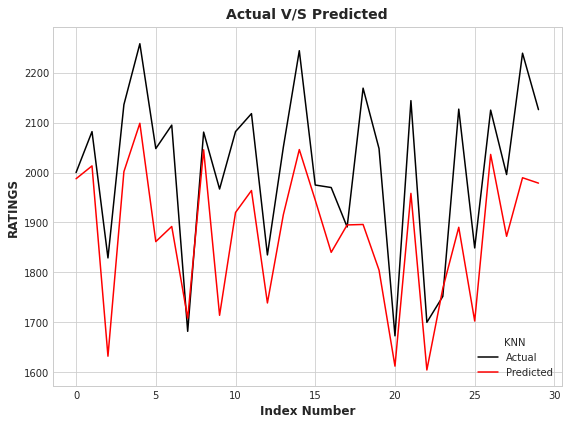

In [27]:
y_pred = np.array(y_pred).flatten()
y_test = np.array([y_test]).flatten()
check = pd.DataFrame({'Actual': y_test, 'Predicted': np.round(y_pred,2)})

plt.figure(figsize=(8,6))
plt.plot(check['Actual'][0:30],label = 'Actual',color='black')
plt.plot(check['Predicted'][0:30],label = 'Predicted',color='r')
plt.title("Actual V/S Predicted")
plt.xlabel('Index Number')
plt.ylabel('RATINGS')
plt.legend(title = 'KNN')
plt.show()

Before going forward, let's attempt to tune hyperparameters via grid search:

In [41]:
grid_params = {'n_neighbors' : [5,9,13,15],
               'metric' : ['euclidean','manhattan']}

In [25]:
gs = GridSearchCV(KNeighborsRegressor(), grid_params,
                  verbose=1, cv=3, n_jobs=-1,
                  scoring=rmse)

In [26]:
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [28]:
g_res.best_score_

139.51366016328168

In [29]:
g_res.best_params_

{'metric': 'euclidean', 'n_neighbors': 5}

In [30]:
print("This is updated model RMSE using GRIDSEARCHCV : ")
metrics.mean_squared_error(y_train, g_res.predict(X_train), squared=False)

This is updated model RMSE using GRIDSEARCHCV : 


111.84120394048452

In [31]:
print("This is updated model RMSE using GRIDSEARCHCV : ")
metrics.mean_squared_error(y_test, g_res.predict(X_test), squared=False)

This is updated model RMSE using GRIDSEARCHCV : 


162.0879491561218

Visualizing (again):

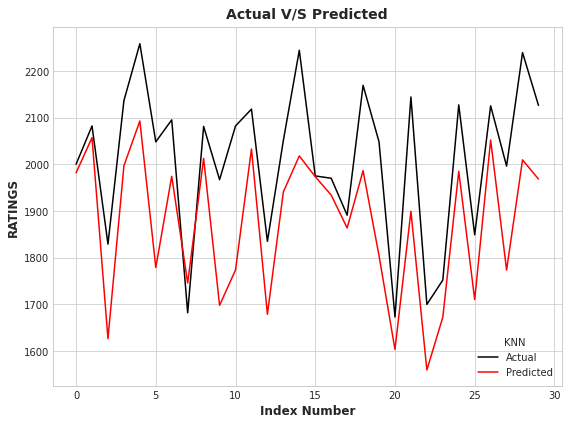

In [44]:
y_pred = np.array(g_res.predict(X_test)).flatten()
y_test = np.array([y_test]).flatten()
check = pd.DataFrame({'Actual': y_test, 'Predicted': np.round(y_pred,2)})

plt.figure(figsize=(8,6))
plt.plot(check['Actual'][0:30],label = 'Actual',color='black')
plt.plot(check['Predicted'][0:30],label = 'Predicted',color='r')
plt.title("Actual V/S Predicted")
plt.xlabel('Index Number')
plt.ylabel('RATINGS')
plt.legend(title = 'KNN')
plt.show()

### ii. Using a Decision Tree

In [32]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn import metrics

In [33]:
clf = DecisionTreeRegressor(max_depth=10)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [34]:
metrics.mean_squared_error(y_test, y_pred, squared=False)

181.12369450255125

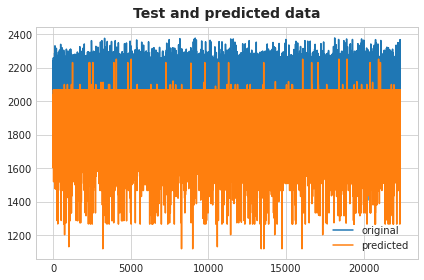

In [36]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

## 3 b) Parametric 

### i. Using SVM

Let's do the same SVR as before - but now, let's try to gauge how well the model generalizes to test data (instead of just training/validation data):

In [37]:
from sklearn.svm import LinearSVR

In [38]:
svr = LinearSVR(random_state=42, C=1.0)
svr.fit(X_train, y_train.values.ravel())

LinearSVR(random_state=42)

In [39]:
rmse_svr_train = root_mean_squared_error(y_train, svr.predict(X_train))
rmse_svr_test = root_mean_squared_error(y_test, svr.predict(X_test))
print(f"RMSE of SVR (train): {rmse_svr_train}.")
print(f"RMSE of SVR (test): {rmse_svr_test}.")

RMSE of SVR (train): 148.2885294538941.
RMSE of SVR (test): 170.59651016139333.


Hmph! So the train RMSE is indeed reproducible. The error is greater for both train/test data compared to the KNN, but the train-test skew is lower signalling it generalizes better.

Visualization time!

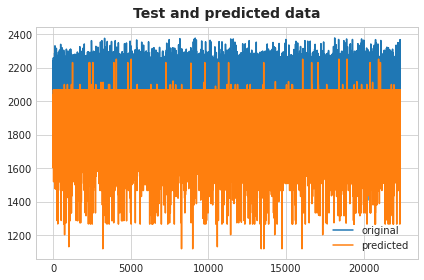

In [40]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data")
plt.legend()
plt.show()

### ii. Using a Multilayer Perceptron

Let's up the ante here, by tuning the regularization (i.e. `alpha`) and learning rate parameters on our prior neural network:

In [ ]:
from sklearn.neural_network import MLPRegressor

from functools import partial

For now, each of our experiments with the MLP will use the same max number of epochs, as well as a random state (to improve reproducibility).

So, let's pre-load the default `MLPRegressor` class with these arguments:

In [ ]:
BiryaniMLPRegressor = partial(MLPRegressor,
                              random_state=1,
                              max_iter=500)

Now, let's go ahead and run a few trials of this model:

In [ ]:
nn_regr1 = BiryaniMLPRegressor(alpha=0.0001)\
          .fit(X_train, y_train.values.ravel())

In [ ]:
nn_regr2 = BiryaniMLPRegressor(alpha=0.001)\
          .fit(X_train, y_train.values.ravel())

In [ ]:
nn_regr3 = BiryaniMLPRegressor(alpha=0.01)\
          .fit(X_train, y_train.values.ravel())

In [ ]:
nn_regr4 = BiryaniMLPRegressor(alpha=0.1).fit(X_train, y_train.values.ravel())

In [ ]:
# keeps the learning rate constant while the model is improving, and then gradually decreases
nn_regr5 = BiryaniMLPRegressor(alpha=0.01, learning_rate='adaptive')\
          .fit(X_train, y_train.values.ravel())

OK, so five models in and we have not yet converged. Let's use that hint from Scikit-learn and try to optimize further, by increasing the number of epochs:

In [ ]:
nn_regr6 = BiryaniMLPRegressor(max_iter=1000, alpha=0.01, 
                               learning_rate='adaptive').fit(X_train, y_train.values.ravel())

Not quite there yet - let's try 2000 epochs:

In [ ]:
nn_regr7 = BiryaniMLPRegressor(max_iter=2000, alpha=0.01, 
                               learning_rate='adaptive').fit(X_train, y_train.values.ravel())

And now before moving forward, let's evaluate this model on the train/test set:

In [ ]:
rmse_nn_train = root_mean_squared_error(y_train, nn_regr7.predict(X_train))
rmse_nn_test = root_mean_squared_error(y_test, nn_regr7.predict(X_test))
print(f"RMSE of MLP (train): {rmse_nn_train}.")
print(f"RMSE of MLP (test): {rmse_nn_test}.")

Hmm, it looks like the multilayer perceptron has the best train loss so far. Nonetheless, this suggests it has the potential to be effective for this dataset. It would be definitely be valuable (time-permitting) to see how we can address the overfitting of this model, such as through hyperparameter tuning.

## 3 c) Stacking Model (using Linear Regression)

Justifications for Stacking Model #1:

- we choose to use `RidgeCV` as the meta-regressor because:
    - we don't need to do use `l1` regularization - since we have already performed feature selection ourselves above
    - cross validation (i.e. only letting the base learners train on some folds of the training data, and not others) will mitigate the chances of overfitting (which is common in naive stacking)
    
- for model 1, we choose the following for the base learners
    - `SGDRegressor` - this is a good "catch-all" kind of model, which can handle both non-linearly separable and linearly separable datasets. It also scales better to datasets with more than 10,000 examples (such as our own) than would a model like the `SVR` ([source](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)).
    - `DecisionTreeRegressor` - by including this model, we can ensure the meta-classifier doesn't only learn from just 1 base (which is important for this to be an ensemble). I also like that it's non-parametric, so it contrasts well with the `SGDRegressor` and is also very explainable ([source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)).
    
- we implement the model using sklearn ([source](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor)).

### Ok, now let's implement the initial model!

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
stacking_base1 = [
    ('dtr', DecisionTreeRegressor(criterion="squared_error",
                                  random_state=42)),
    ('sgdr', SGDRegressor(loss="squared_error",
                          random_state=42,
                          max_iter=2000))
]

stacking_model1 = StackingRegressor(
    estimators=stacking_base1,
    final_estimator=RidgeCV(cv=5, scoring=rmse)
)

stacking_model1 = stacking_model1.fit(X_train, np.squeeze(y_train))

In [ ]:
display(stacking_model1.score(X_train, y_train))
display(stacking_model1.score(X_test , y_test ))

In [ ]:
train_rmse = cross_val_score(stacking_model1, 
                             X_train, y_train.values.ravel(), 
                             cv=5, scoring=rmse)
print(train_rmse.mean())

test_rmse = cross_val_score(stacking_model1, 
                            X_test, y_test.values.ravel(), 
                            cv=5, scoring=rmse)
print(test_rmse.mean())

In [ ]:
plt.bar(["1", "2", "3", "4", "5"],
        train_rmse)
plt.title("K-Fold Cross Validation of Stacking Regressor 1 (Train)")
plt.ylabel("RMSE")
plt.xlabel("Fold Number")
plt.show()

In [ ]:
plt.bar(["1", "2", "3", "4", "5"],
        test_rmse)
plt.title("K-Fold Cross Validation of Stacking Regressor 1 (Test)")
plt.ylabel("RMSE")
plt.xlabel("Fold Number")
plt.show()

Interesting! The output of the `score()` method is the R^2 score, which is much higher for our training data than our test data. Which means we've probably started overfitting.

Let me go back on what I said earlier - a model that uses l1 regularization might actually be worth a shot here. Even though the number of columns in our data is small, due to one hot encoding we actually do have a lot of features (17 to be exact). So I'm curious to see if a `Lasso` model could help us perform better, by ignoring the features that really shouldn't be accounted for:

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

stacking_model2 = StackingRegressor(
    estimators=stacking_base1,
    final_estimator=linear_model.Lasso()
)
stacking_model2 = stacking_model2.fit(X_train, np.squeeze(y_train))

print(cross_val_score(stacking_model2, 
                      X_train, y_train.values.ravel(), 
                      cv=5, scoring=rmse))

print(cross_val_score(stacking_model2, 
                      X_test, y_test.values.ravel(), 
                      cv=5, scoring=rmse))

In [ ]:
display(stacking_model2.score(X_train, y_train))
display(stacking_model2.score(X_test , y_test ))

Nevermind! The loss values above are about the same.

This is further evidence that we have started overfitting - as we can see for the output of `cross_val_score`, on the test set, the R^2 score for these models widely varies based on different splits of the data. This suggests that our model might have become overly sensitive to potential "noise" (e.g. outliers, too many features, multicolinearity) in our data.

## Create the Final Test Predictions

In [ ]:
full_test_of_players = full_test[~full_test["nickname"].isin(bot_names)]

In [ ]:
numerical_features_test = full_test_of_players[numerical_features]
categorical_features_test = full_test_of_players[categorical_features]

X_cat_test = enc.transform(full_test_of_players[categorical_features]).toarray()

numerical_features_test_scaled = scaler.transform(numerical_features_test)

In [ ]:
X_test_players = np.column_stack([X_cat_test, numerical_features_test_scaled])

Now let's actually create our predictions:

In [ ]:
final_test_preds = stacking_model1.predict(X_test_players)

In [ ]:
full_test_of_players.loc[:, ('rating')] = final_test_preds
submission = full_test_of_players[["game_id", "rating"]]
submission.to_csv("/kaggle/working/submission.csv", index=False)